# スクラッチでの多層パーセプトロン実装

参照： https://github.com/dennybritz/nn-from-scratch/blob/master/nn-from-scratch.ipynb

In [82]:
# パッケージインポート
import numpy as np
import sklearn
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

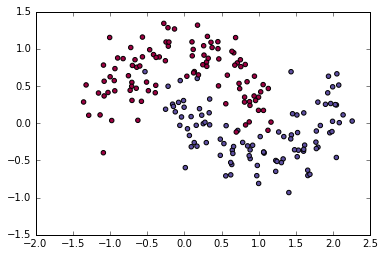

In [83]:
# データ生成
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)

In [84]:
#sklearnによるロジスティック回帰モデル例作成
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [85]:
# 決定境界線を出力する補助関数
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

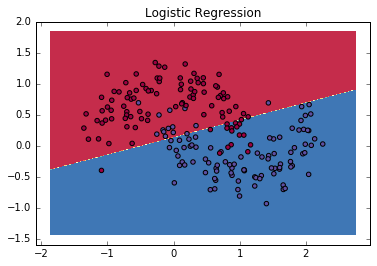

In [86]:
# 決定境界線を出力する
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

In [87]:
num_example = len(X) # 学習用データ数
nn_input_dim = 2 # 入力層の次元数(ユニット数)
nn_output_dim = 2 # 出力層の次元数(ユニット数)

# 勾配降下のパラメータ
epsilon = 0.01 # 勾配降下の学習係数
reg_lambda = 0.01 # 正則化の強度

In [88]:
# データセット上の全損失を計測する関数
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # 予測を算出するための順伝播
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2)
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # 損失を計算
    corect_logprobs = -np.log(probs[range(num_example), y])
    data_loss = np.sum(corect_logprobs)
    # 損失に正則化項を追加(オプション)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1) + np.sum(np.square(W2))))
    return 1./num_example * data_loss

In [89]:
# output予測の補助関数
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # 順伝播
    z1 = x.dot (W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_score = np.exp(z2)
    probs = exp_score / np.sum(exp_score, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [90]:
# ニューラルネットワークのパラメータとモデルを返す関数
# - nn_hdim: 隠れ層のノード数
# - num_passes: 勾配降下のトレーニングデータ通過数
# - pront_loss: Trueの場合、1000イテレーションごとの損失を表示する
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    #　乱数値のパラメータを初期化する。これらを学習させる必要がある。
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    
    # 関数の終了時にこれを返す
    model = {}
    
    # バッチごとに勾配降下
    for i in range(0, num_passes):
        
        # 順伝播
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_score = np.exp(z2)
        probs = exp_score / np.sum(exp_score, axis=1, keepdims=True)
        
        # 逆伝播
        delta3 = probs
        delta3[range(num_example), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        # 正則化項を追加する
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        
        # 勾配降下のパラメータ更新
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # モデルに新しいパラメータを割り当てる
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # (オプション)損失を表示
        # データセット全体を使用するため高負荷。頻繁に使用すべきではない。
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model))) 
            
    return model

Loss after iteration 0: 0.434201
Loss after iteration 1000: 0.094140
Loss after iteration 2000: 0.111602
Loss after iteration 3000: 0.124227
Loss after iteration 4000: 0.128221
Loss after iteration 5000: 0.130647
Loss after iteration 6000: 0.132152
Loss after iteration 7000: 0.133088
Loss after iteration 8000: 0.133670
Loss after iteration 9000: 0.134031
Loss after iteration 10000: 0.134254
Loss after iteration 11000: 0.134391
Loss after iteration 12000: 0.134476
Loss after iteration 13000: 0.134528
Loss after iteration 14000: 0.134559
Loss after iteration 15000: 0.134579
Loss after iteration 16000: 0.134590
Loss after iteration 17000: 0.134597
Loss after iteration 18000: 0.134602
Loss after iteration 19000: 0.134604


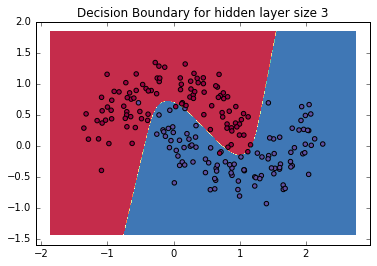

In [91]:
# ３次元の隠れ層を持つモデルの生成
model = build_model(3, print_loss=True)

# 決定境界線のプロット
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

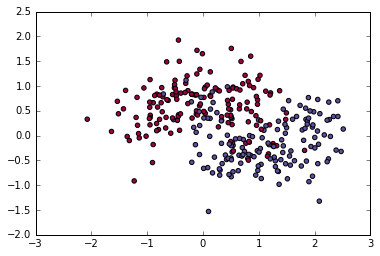

In [100]:
# シード値の異なるデータ生成
np.random.seed(6)
X, y = sklearn.datasets.make_moons(300, noise=0.40)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)

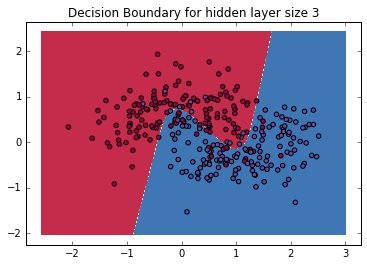

In [101]:
# 別データで予測した決定境界線をプロット
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")